# Plot of Figure 3: Bilayer with Interlayer coupling AND moirè potential

Usage:

1. Chose the parameters from the first block
2. Run the second block EVERY TIME you change the parameters. Automatically plots the result
3. If you want to save the final intensities, run the 3th block.

## Parameters
1. `saveE` and `saveW` decide whether the energies and intensities are saved locally on the laptop, in this way you don't need to re-evaluate the same parameters each time.
2. Parameters which influence the bands, and so you need new energy evaluation for each change, are:
    - `kPts` sets the number of points in the BZ cut Gamma - K - Kp
    - `theta` is the twist angle -> 2.8° for S11
    - `Vg`, `phiG`, `Vk` and `phiK` are the moire potentials at Gamma (out-of-plane orbitals) and K (in-plane orbitals). Values from EDC fitting yield Gamma=(0.017,175°), K=(0.006,-106°)
    - `w1p` and `w1d` are the interlayer couplings. Values from EDC fitting yield (-1.66, 0.324)
3. Parameters which influence the intensity matrix, and so you need a new intensity evaluation for each change, are:
    - `typeSpread` (either 'Gauss' or 'Lorentz') decides which function is used to spread the weights
    - `spreadK` gives the spreading in k-direction
    - `spreadE` gives the spreading in energy-direction
    - `E_max` and `E_min` (in eV) specifies the energ window
    - `deltaE` decides the spacing of the energy axis
    - `shadeFactor` is a coefficient multiplied to the weights coming from the orbitals of the WS2. It is used in order to have an image more similar to the experimental one since it shades away the bands near K of WS2
    - `powFactor` is the exponent of the intensities. For factor 2 we should have the ARPES intensities, in order to highlight the sidebands we can use a smaller value (usually between 1 and 2)
    - `minimumBand` tells which is the lowest band considered to contribute on the intensities. Since the energy window is fixed, there is no need to consider all the bands down to the lowest one, in order to save computation time. There are 44 bands in total (times # of mini-BZs), with TVB at 28.
4. Parameters of final plot. Changing these affects only the plotting, no new calculation is needed
    - `shadeFactorE` is an additional shading which depends just on the energy and is linear. Starts from 1 at `E_max` and goes down to this factor at `E_min`
    - `indKplus` is the number of additional k-points after the K point in the K-Gamma-Kp plot
    - `indKG` is the number of additional k-points after the K point in the K-Kp plot.

In [2]:
import numpy as np

""" Save energy and intensities """
saveE = True
saveW = True

""" Bilayer parameters -> changing any of these you need to re-evaluate the energies """
kPts = 200         # Points in the cut G -> K -> K'
theta = 2.8     # twisting angle, in deg
Vg = 0.017              # eV
phiG = 175/180*np.pi        # rad
Vk = 0.006              # eV
phiK = -106/180*np.pi       # rad
w1p = -1.66         # eV
w1d = 0.324         # eV

""" Parameters of intensity matrix -> changing any of these you need to re-evaluate the intensities """
typeSpread = 'Gauss'    # 'Gauss' or 'Lorentz', works for both k and E
spreadK = 0.005     # in 1/a
spreadE = 0.015      # in eV
E_max = 0           # in eV
E_min = -2.5        # in eV
deltaE = 0.01       # in eV, sets the energy grid
shadeFactorWS2 = 0.1     # shade factor of WS2 -> 0 (not visible at all) to 1 (same relevance as WSe2)
# we could also put another shading depending on the energy -> lower bands get less weight
powFactor = 1.       # exponent of weights -> 2 is the usual mod square of eigenvectors which should be the weight of ARPES spectra. For lower values we enhance the intensity of the side bands
minimumBand = 15    # lowest considered band for spreading      #bands are 0 to 43, with TVB at 27

""" Parameters of final plot """
shadeFactorE = 0.1 # Add a linar shading depending on the energy. Starts at 1 at E_max and goes to this factor at E_min
indKplus = 5   # number of additional points (out of kPts//2-1) after the K point on the 2 sides)
indKG = 50   # number of additional points (out of kPts//2) after the K point on the 2 sides, towards G

Computing energies


Diagonalization of Hamiltonian: 100%|█████████████████████████████████████████████████| 199/199 [00:52<00:00,  3.78it/s]


Computing intensities


100%|█████████████████████████████████████████████████████████████████████████████████| 199/199 [00:03<00:00, 58.09it/s]


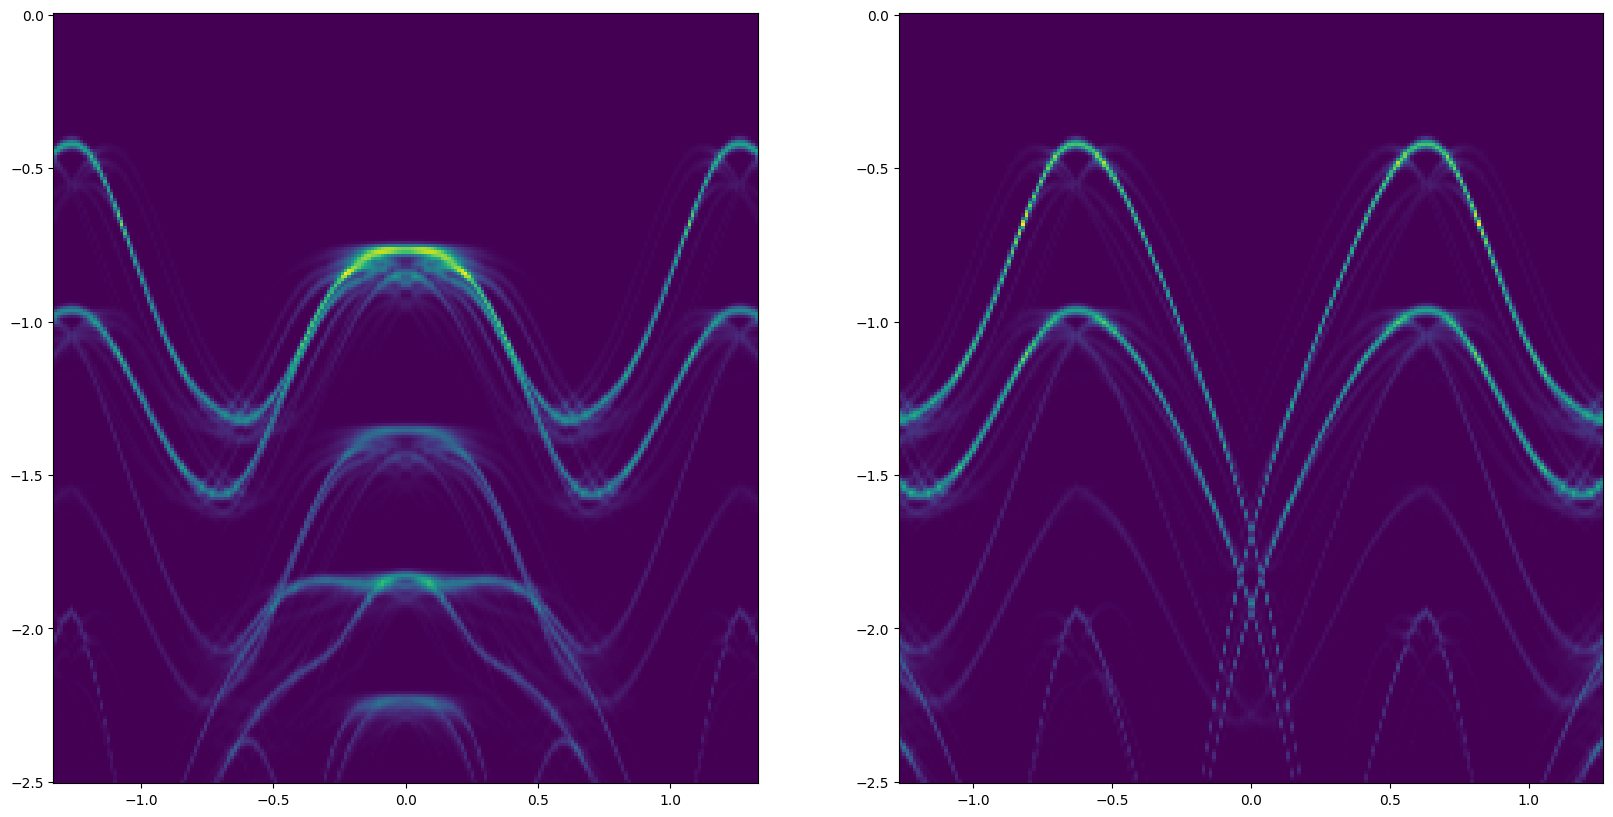

In [3]:
""" Actual computation """

""" Import libraries and functions """
import sys, os
cwd = os.getcwd()
import CORE_functions as cfs
import functions as fs
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

""" Interlayer parameters """
sample = 'S11'
stacking = 'P'
w2p = w2d = 0
parsInterlayer = {'stacking':stacking,'w1p':w1p,'w2p':w2p,'w1d':w1d,'w2d':w2d}
nShells = 2
nCells = int(1+3*nShells*(nShells+1))
monolayer_type = 'fit'
moire_pars = (Vg,Vk,phiG,phiK)
""" BZ path """
kList,norm = cfs.get_kList('G-K-Kp',kPts,returnNorm=True)
if 0:   # Plot BZ cut
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(kList[:,0],kList[:,1])
    ax.set_aspect('equal')
    plt.show()
kPts = kList.shape[0]
K0 = 4*np.pi/3/cfs.dic_params_a_mono['WSe2']
""" Computing evals and evecs """
args_e_data = (sample,nShells,monolayer_type,Vk,phiK,theta,stacking,w1p,w1d,phiG,kPts)
th_e_data_fn = cfs.getFilename(('fig3_e',)+args_e_data,dirname='Data/',extension='.npz')
if not Path(th_e_data_fn).is_file():
    print("Computing energies")
    args = (nShells, nCells, kList, monolayer_type, parsInterlayer, theta, moire_pars, '', False, True)
    evalsFull, evecsFull = fs.diagonalize_matrix(*args)
    evals = evalsFull[:,nCells*minimumBand:nCells*28]
    evecs = evecsFull[:,:,nCells*minimumBand:nCells*28]
    if saveE:
        np.savez(th_e_data_fn,evals=evals,evecs=evecs,norm=norm,kList=kList)
else:
    print("Loading energies")
    evals = np.load(th_e_data_fn)['evals']
    evecs = np.load(th_e_data_fn)['evecs']
    norm = np.load(th_e_data_fn)['norm']
""" Computing weights and spread image """
pars_spread = ( spreadK, spreadE, typeSpread, deltaE, powFactor, shadeFactorWS2, minimumBand)
args_w_data = args_e_data + pars_spread
th_w_data_fn = cfs.getFilename(('fig3_w',)+args_w_data,dirname='Data/',extension='.npz')
if not Path(th_w_data_fn).is_file():
    print("Computing intensities")
    weights = np.zeros((kPts,nCells*(28-minimumBand)))
    for i in range(kPts):
        ab = np.absolute(evecs[i])**powFactor
        weights[i,:] = np.sum(ab[:22,:],axis=0) + shadeFactorWS2*np.sum(ab[22*nCells:22*(1+nCells),:],axis=0)
    _, _, pKi, pKf, pEmax, pEmin = cfs.dic_pars_samples[sample]
    eList = np.linspace(E_min,E_max,int((E_max-E_min)/deltaE))
    spread = np.zeros((kPts,len(eList)))
    for i in tqdm(range(kPts)):
        for n in range(nCells*(28-minimumBand)):#,nCells*28):
            spread += fs.weight_spreading(weights[i,n],kList[i],evals[i,n],kList,eList[None,:],pars_spread[:3])
    if saveW:
        np.savez(th_w_data_fn,spread=spread,eList=eList)
else:
    print("Loading intensities")
    eList = np.load(th_w_data_fn)['eList']
    spread = np.load(th_w_data_fn)['spread']
""" Patch intensities """
indK = np.argmin(abs(norm-K0))
spGK = spread[:indK+1,:]    # with K-point
spKKp = spread[indK:,:]     # with K-point

spKplus = spKKp[1:indKplus+1]      # additional points 
spKGK = np.concatenate([
    spKplus[::-1,:],        # k+ -> K(ex)
    spGK[1:][::-1],             # K (in) -> G (ex)
    spGK[1:],               # Gamma (ex) -> K (in)
    spKplus                 # K (ex) -> k+
],axis=0)

spKplus2 = spGK[-1-indKG:,]        # additional points
spKKp = np.concatenate([
    spKplus2[:-1],           # k- -> K(ex)
    spKKp,                  # K (in) -> Kp (ex)
    spKplus2[::-1,:]         # K (in) -> k-
],axis=0)
# Shading
shadeE = np.linspace(shadeFactorE,1,len(eList))
spKGK *= shadeE[None,:]
spKKp *= shadeE[None,:]

# Momentum values
normGK = norm[:indK+1]      # with K
normKKp = norm[indK:]       # with K
normKplus = norm[1:indKplus+1]
K1 = np.concatenate([
    -K0-normKplus[::-1],
    -normGK[1:][::-1],
    normGK[1:],
    K0+normKplus
])
normKplus2 = normGK[-1-indKG:]
K2 = np.concatenate([
    normKplus2[:-1],
    normKKp,
    3*K0-normKplus2[::-1]
])  - 3/2*K0        # cetered in M

""" Plotting """
if 0:       # Plot with imshow -> fast but no axes
    fig = plt.figure(figsize=(20,10))

    ax1 = fig.add_subplot(121)      # K->G->Kp plot
    imKGK = spKGK[:,::-1].T
    ax1.imshow(
        imKGK,
        cmap='berlin',
    )
    ax2 = fig.add_subplot(122)      # K->Kp plot 
    imKKp = spKKp[:,::-1].T
    ax2.imshow(
        imKKp,
        cmap='berlin',
    )
    plt.show()
if 1:       # Plot with pcolormesh
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(121)      # K->G->Kp plot
    ax1.pcolormesh(
        K1,eList,
        spKGK.T,
        cmap='viridis',
        shading="auto"
    )

    ax2 = fig.add_subplot(122)      # K->Kp plot
    ax2.pcolormesh(
        K2,eList,
        spKKp.T,
        cmap='viridis',
        shading='auto'
    )
    plt.show()

In [ ]:
""" Run this part to save as .csv file the last plotted intensities and the momentum/energy values"""
fnKGK = 'Data/intensity_K-G-Kp.csv'
np.savetxt(fnKGK, spKGK, delimiter=",")
fnKGKm = 'Data/momenta_K-G-Kp.csv'
np.savetxt(fnKGKm, K1, delimiter=",")
fnKGKe = 'Data/energy_K-G-Kp.csv'
np.savetxt(fnKGKe, eList, delimiter=",")

fnKK = 'Data/intensity_K-Kp.csv'
np.savetxt(fnKK, spKKp, delimiter=",")
fnKKm = 'Data/momenta_K-Kp.csv'
np.savetxt(fnKKm, K2, delimiter=",")
fnKKe = 'Data/energy_K-Kp.csv'
np.savetxt(fnKKe, eList, delimiter=",")